In [1]:
# Run if you haven't installed libraries already
!pip install -q scikit-learn pandas numpy matplotlib seaborn joblib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


In [3]:
df = pd.read_csv("../data/final_output.csv")
print("Shape:", df.shape)
display(df.head())
display(df.info())


Shape: (3063, 11)


,car_age,year,owner,km_driven,brand_name_Mahindra,brand_name_Tata,brand_name_Toyota,brand_popularity,brand_name_Honda,brand_name_Chevrolet,selling_price
0,0.684211,0.315789,0,0.421683,0.0,0.0,0.0,1.000000,0.0,0.0,60000.000000
1,0.684211,0.315789,0,0.301201,0.0,0.0,0.0,1.000000,0.0,0.0,504355.832295
2,0.421053,0.578947,0,0.602407,0.0,0.0,0.0,0.578947,0.0,0.0,600000.000000
3,0.157895,0.842105,0,0.277104,0.0,0.0,0.0,0.026316,0.0,0.0,250000.000000
4,0.315789,0.684211,2,0.849397,0.0,0.0,0.0,0.188259,1.0,0.0,450000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3063 entries, 0 to 3062
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   car_age               3063 non-null   float64
 1   year                  3063 non-null   float64
 2   owner                 3063 non-null   int64  
 3   km_driven             3063 non-null   float64
 4   brand_name_Mahindra   3063 non-null   float64
 5   brand_name_Tata       3063 non-null   float64
 6   brand_name_Toyota     3063 non-null   float64
 7   brand_popularity      3063 non-null   float64
 8   brand_name_Honda      3063 non-null   float64
 9   brand_name_Chevrolet  3063 non-null   float64
 10  selling_price         3063 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 263.4 KB


None

In [4]:
target_col = 'selling_price'
if target_col not in df.columns:
    raise ValueError(f"Target '{target_col}' not found. Columns: {df.columns.tolist()}")
features = df.columns.drop(target_col)
print("Target:", target_col)
print("Number of features:", len(features))
display(features.tolist())


Target: selling_price
Number of features: 10


['car_age',
 'year',
 'owner',
 'km_driven',
 'brand_name_Mahindra',
 'brand_name_Tata',
 'brand_name_Toyota',
 'brand_popularity',
 'brand_name_Honda',
 'brand_name_Chevrolet']

In [5]:

# Drop rows missing target, fill other missing sensibly
df = df.dropna(subset=[target_col]).copy()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

print("After cleaning shape:", df.shape)


After cleaning shape: (3063, 11)


In [6]:

X = df.drop(columns=[target_col])
X = pd.get_dummies(X, drop_first=True)   # one-hot encode
y = df[target_col]

print("X shape:", X.shape)
display(X.head())


X shape: (3063, 10)


,car_age,year,owner,km_driven,brand_name_Mahindra,brand_name_Tata,brand_name_Toyota,brand_popularity,brand_name_Honda,brand_name_Chevrolet
0,0.684211,0.315789,0,0.421683,0.0,0.0,0.0,1.000000,0.0,0.0
1,0.684211,0.315789,0,0.301201,0.0,0.0,0.0,1.000000,0.0,0.0
2,0.421053,0.578947,0,0.602407,0.0,0.0,0.0,0.578947,0.0,0.0
3,0.157895,0.842105,0,0.277104,0.0,0.0,0.0,0.026316,0.0,0.0
4,0.315789,0.684211,2,0.849397,0.0,0.0,0.0,0.188259,1.0,0.0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (2450, 10)  Test: (613, 10)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Save the scaler
joblib.dump(scaler, "../results/outputs/IT24100507_scaler.joblib")

print("Scaling done and scaler saved!")

Scaling done and scaler saved!


In [9]:

base_model = DecisionTreeRegressor(random_state=42)
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)
r2_base = r2_score(y_test, y_pred_base)
mae_base = mean_absolute_error(y_test, y_pred_base)
print(f"BASE -> R2: {r2_base:.4f}, MAE: {mae_base:.2f}")


BASE -> R2: 0.2960, MAE: 148446.06


In [10]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid = GridSearchCV(DecisionTreeRegressor(random_state=42),
                    param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
best_tree = grid.best_estimator_
y_pred_tuned = best_tree.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
print("Best params:", grid.best_params_)
print(f"TUNED -> R2: {r2_tuned:.4f}, MAE: {mae_tuned:.2f}")

joblib.dump(scaler, "../results/outputs/IT24100507_best_decision_tree.joblib")


Best params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
TUNED -> R2: 0.5171, MAE: 125734.21


['../results/outputs/IT24100507_best_decision_tree.joblib']

In [11]:
from sklearn.decomposition import PCA
n_components = min(10, X_train.shape[1])
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

pca_tree = DecisionTreeRegressor(random_state=42, max_depth=7)
pca_tree.fit(X_train_pca, y_train)
y_pred_pca = pca_tree.predict(X_test_pca)
r2_pca = r2_score(y_test, y_pred_pca)
mae_pca = mean_absolute_error(y_test, y_pred_pca)
print(f"PCA MODEL -> n_components={n_components} R2: {r2_pca:.4f}, MAE: {mae_pca:.2f}")

joblib.dump(scaler, "../results/outputs/IT24100507_pca_transform.joblibe")
joblib.dump(scaler, "../results/outputs/IT24100507_pca_tree.joblib")



PCA MODEL -> n_components=10 R2: 0.4606, MAE: 132143.96


['../results/outputs/IT24100507_pca_tree.joblib']

In [12]:
pruned_model = DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_leaf=2)
pruned_model.fit(X_train, y_train)
y_pred_pruned = pruned_model.predict(X_test)
r2_pruned = r2_score(y_test, y_pred_pruned)
mae_pruned = mean_absolute_error(y_test, y_pred_pruned)
print(f"PRUNED MODEL -> R2: {r2_pruned:.4f}, MAE: {mae_pruned:.2f}")


joblib.dump(pruned_model, "../results/outputs/IT24100507_pruned_tree.joblib")




PRUNED MODEL -> R2: 0.5117, MAE: 126147.86


['../results/outputs/IT24100507_pruned_tree.joblib']

In [13]:
cv_scores = cross_val_score(best_tree, X, y, cv=5, scoring='r2', n_jobs=-1)
print(f"Tuned model CV R2 mean: {cv_scores.mean():.4f}, std: {cv_scores.std():.4f}")


Tuned model CV R2 mean: 0.5215, std: 0.0376


=== Decision Tree Regressor - Model Comparison (All 4 Varieties) ===


,Model,R2,MAE
1,Tuned,0.517094,125734.214006
3,Pruned,0.511684,126147.861827
2,PCA,0.460630,132143.961024
0,Base,0.295985,148446.058845


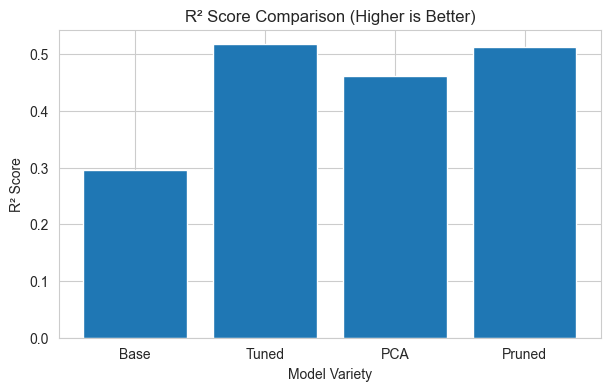

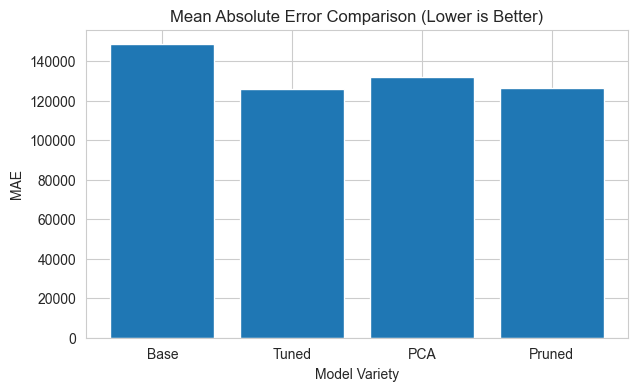

✅ Results saved successfully at: ../results/outputs/IT24100507_dt_results.csv
    Model        R2            MAE
0    Base  0.295985  148446.058845
1   Tuned  0.517094  125734.214006
2     PCA  0.460630  132143.961024
3  Pruned  0.511684  126147.861827


In [14]:
# === Compare All 4 Varieties of Decision Tree Regressor ===
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with model results
results_all = pd.DataFrame({
    'Model': ['Base', 'Tuned', 'PCA', 'Pruned'],
    'R2': [r2_base, r2_tuned, r2_pca, r2_pruned],
    'MAE': [mae_base, mae_tuned, mae_pca, mae_pruned]
})

# Display the table sorted by R² (best model first)
print("=== Decision Tree Regressor - Model Comparison (All 4 Varieties) ===")
display(results_all.sort_values('R2', ascending=False))

# --- Plot R² Comparison (Higher is Better) ---
plt.figure(figsize=(7,4))
plt.bar(results_all['Model'], results_all['R2'])
plt.title("R² Score Comparison (Higher is Better)")
plt.xlabel("Model Variety")
plt.ylabel("R² Score")
plot_path = "../results/eda_visualizations/IT24100507_r2_comparisonpng.png"
plt.savefig(plot_path)
plt.show()

# --- Plot MAE Comparison (Lower is Better) ---
plt.figure(figsize=(7,4))
plt.bar(results_all['Model'], results_all['MAE'])
plt.title("Mean Absolute Error Comparison (Lower is Better)")
plt.xlabel("Model Variety")
plt.ylabel("MAE")
plot_path = "../results/eda_visualizations/IT24100507_mae_comparison.png"
plt.savefig(plot_path)
plt.show()

# --- (Optional) Save results for your report ---
#results_all.to_csv("decision_tree_all_varieties_comparison.csv", index=False)
#print("✅ Saved results as decision_tree_all_varieties_comparison.csv")

# --- Save Results ---
results_df = results_all  # use the DataFrame you already created
csv_path = "../results/outputs/IT24100507_dt_results.csv"
results_df.to_csv(csv_path, index=False)
print("✅ Results saved successfully at:", csv_path)
print(results_df)




